In [2]:
import numpy as np
import math
import torch
from torch import nn

from Inference.EnsembleOfMAP import eMAP

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator
from Metrics import RMSE, PICP, MPIW

from tempfile import TemporaryDirectory


In [3]:
import torch
from torch import nn
import math

from tqdm import trange


from Tools import KL, batchKL

#regularizer for the KL
rho=1.

class FuNNeVI():
    def __init__(self, loglikelihood, batch, size_data, prior, projection, n_samples_FU, ratio_ood, p,
                 kNNE, n_samples_KL, n_samples_LL,
                 max_iter, learning_rate, min_lr, patience, lr_decay,
                 device, llvalid, show=None):
        self.loglikelihood=loglikelihood
        self.batch=batch
        self.size_data=size_data
        self.prior=prior
        self.projection=projection
        self.n_samples_FU=n_samples_FU
        self.ratio_ood=ratio_ood
        self.kNNE=kNNE
        self.n_samples_KL=n_samples_KL
        self.n_samples_LL=n_samples_LL
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.min_lr = min_lr
        self.patience = patience
        self.lr_decay = lr_decay
        self.device = device
        self.llvalid=llvalid
        self.show=show
    
        
        self.p=p



    def ELBO(self,GeN,m_MCL=100,n_LL=200):
        #compute ELBO of GeN accurately
        device=self.device
        theta=GeN(self.n_samples_KL)
        theta_prior=self.prior(self.n_samples_KL)
        theta_proj=torch.Tensor(m_MCL, self.n_samples_KL, self.n_samples_FU).to(device)
        theta_prior_proj=torch.Tensor(m_MCL, self.n_samples_KL, self.n_samples_FU).to(device)
        for i in range(m_MCL):
            t, t_p= self.projection(theta, theta_prior, self.n_samples_FU, self.ratio_ood)
            theta_proj[i], theta_prior_proj[i]= t.detach().cpu(), t_p.detach().cpu()
        
        K=batchKL(theta_proj.detach().cpu(), theta_prior_proj.detach().cpu(),k=self.kNNE,device=device,p=self.p)
        LL = self.loglikelihood(GeN(n_LL).detach()).mean().to(device)
        L = K - LL
        return L
    
    def _KL(self,GeN):
        
        theta=GeN(self.n_samples_KL) #variationnel
        theta_prior=self.prior(self.n_samples_KL) #prior

        theta_proj, theta_prior_proj = self.projection(theta, theta_prior, self.n_samples_FU, self.ratio_ood)

        K=KL(theta_proj, theta_prior_proj,k=self.kNNE,device=self.device,p=self.p)
        return K

        


    def run(self, GeN, show_fn=None):
        one_epoch=int(self.size_data/self.batch)
        
        optimizer = torch.optim.Adam(GeN.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=self.patience, factor=self.lr_decay)

        self.scores={'ELBO': [] ,
                     'KL':[],
                     'LL':[],
                     'lr':[],
                     'LLvalid':[]
                     
        }
        
        
        
        with trange(self.max_iter) as tr:
            for t in tr:
                
                optimizer.zero_grad()
    
                K = self._KL(GeN) #KL(Q_var,Prior)
                LL = self.loglikelihood(GeN(self.n_samples_LL), self.batch).mean()
                L=(self.batch/self.size_data)*rho*K-LL
                L.backward()

                lr = optimizer.param_groups[0]['lr']
                
                
                tr.set_postfix(ELBO=L.item(), LogLike=LL.item(), KL=K.item(), lr=lr)

                optimizer.step()

                LLvalid=self.llvalid(GeN(self.n_samples_LL)).mean()
                self.scores['LLvalid'].append(LLvalid.item())
                
                if t % 100 ==0:
                    self.scores['ELBO'].append(L.item())
                    self.scores['KL'].append(K.item())
                    self.scores['LL'].append(LL.item())
                    self.scores['lr'].append(lr)
                    if self.show is not None:
                        self.show(GeN)

      
                if lr < self.min_lr:
                      break

                
                scheduler.step(L.item())


            return self.ELBO(GeN)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
from Experiments.energy import Setup
setup=Setup(device)


# Target density #

In [6]:
loglikelihood=setup.loglikelihood
projection=setup.projection

size_sample=setup.n_train_samples
param_count=setup.param_count
model=setup._model

X_train, y_train=setup.train_data()
X_test, y_test=setup.test_data()

def prior(n):
    return .5*torch.randn(size=(n,param_count), device=device)

size_sample,param_count

(691, 501)

In [7]:
from Tools import NormalLogLikelihood
def valid_loglikelihood(theta):
    """
    parameters:
        theta (Tensor): M x param_count (models)
        X (Tensor): N x input_dim
        y (Tensor): N x 1
    output:
        LL (Tensor): M x N (models x data)
    """
    y_pred = setup._model(X_test.to(device), theta) # MxNx1 tensor
    #y_pred = self._normalized_prediction(X, theta, device)  # MxNx1 tensor
    return NormalLogLikelihood(y_pred, y_test.to(device), setup.sigma_noise)

# Generative Network #

In [8]:
lat_dim=5


G = BigGenerator(lat_dim,param_count,device).to(device)
#GeN= GeNetEns(1, lat_dim, 50, param_count, activation, 0.2, init_b, device)


In [9]:
%matplotlib inline



optimizer = FuNNeVI(loglikelihood, 100, size_sample, prior, projection, n_samples_FU=150, ratio_ood=1., p=2,
                          kNNE=1, n_samples_KL=1000, n_samples_LL=100, 
                          max_iter=10000, learning_rate=0.005, min_lr=0.001, patience=400, lr_decay=0.7,
                          device=device, llvalid=valid_loglikelihood, show=None
                   )
optimizer.run(G)

100%|██████████| 10000/10000 [04:54<00:00, 33.95it/s, ELBO=122, KL=-24.8, LogLike=-126, lr=0.0012]


tensor(843.7764)

10000
torch.Size([10000])


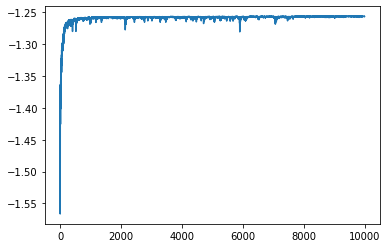

In [10]:
%matplotlib inline
K=torch.as_tensor(optimizer.scores['LLvalid'])
print(K.shape[0])
T=torch.linspace(0,K.shape[0],K.shape[0])
print(T.shape)
plt.plot(T,K)

53
torch.Size([53])


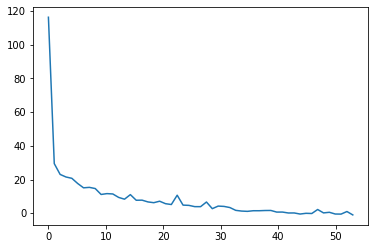

In [48]:
%matplotlib inline
K=torch.as_tensor(optimizer.scores['KL'])
print(K.shape[0])
T=torch.linspace(0,K.shape[0],K.shape[0])
print(T.shape)
plt.plot(T,0.25*K)

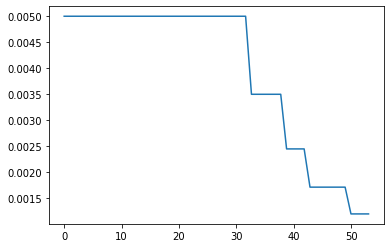

In [49]:
LR=torch.as_tensor(optimizer.scores['lr'])
T=torch.linspace(0,LR.shape[0],LR.shape[0])
plt.plot(T,LR)

53
torch.Size([53])


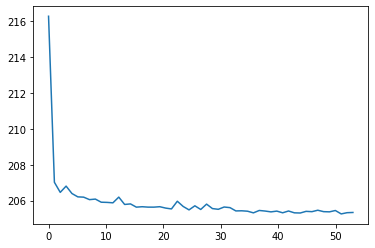

In [50]:
K=torch.as_tensor(optimizer.scores['ELBO'])
print(K.shape[0])
T=torch.linspace(0,K.shape[0],K.shape[0])
print(T.shape)
plt.plot(T,K)

53
torch.Size([53])


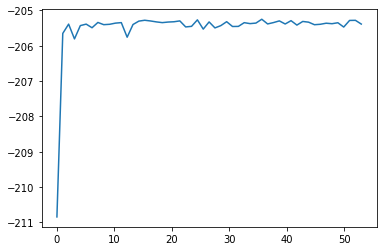

In [51]:
K=torch.as_tensor(optimizer.scores['LL'])
print(K.shape[0])
T=torch.linspace(0,K.shape[0],K.shape[0])
print(T.shape)
plt.plot(T,K)

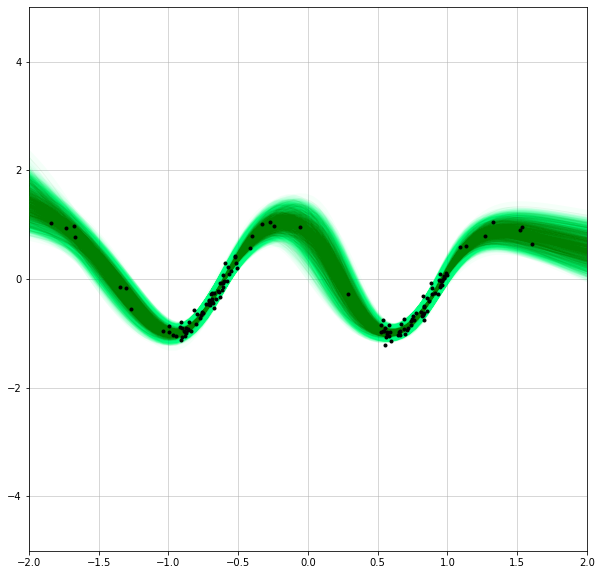

In [51]:
%matplotlib inline
fig=setup.makePlot(G(1000).detach(),device)

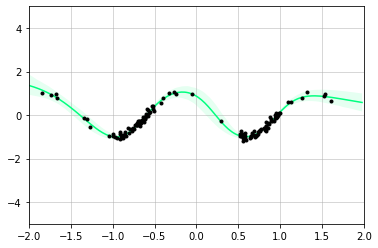

In [52]:
%matplotlib inline
fig=setup.makePlotCI(G(1000).detach(),device)

In [53]:
theta=torch.load('Results/Foong mixed/Foong_mixed_a7b1affe462a4605a41febae43ff6ef7.pt')

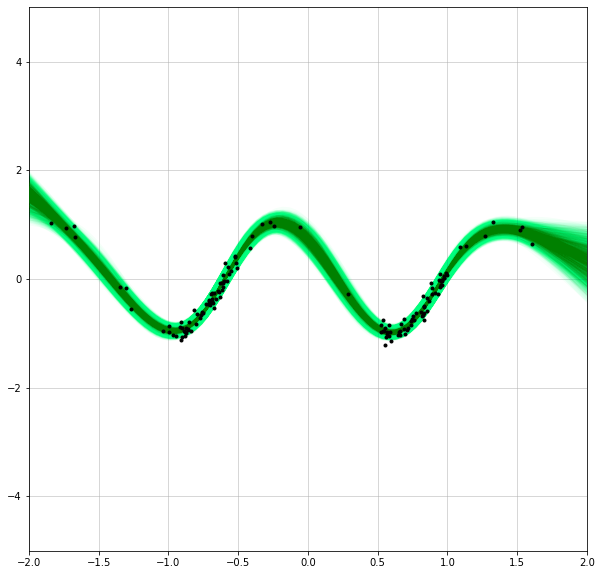

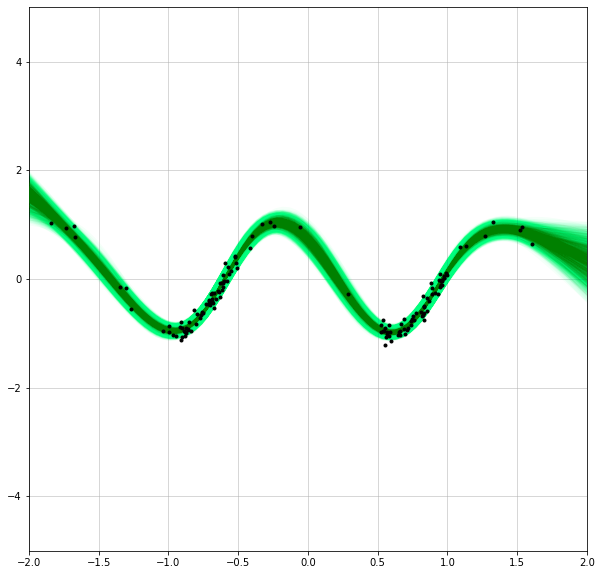

In [54]:
setup.makePlot(theta[::10],device)

In [41]:
import autograd.numpy as np

from autograd import hessian

def f(x):
    y = np.exp(x)
    return y

xx = np.ones(4)
ddf = hessian(f)
print(ddf(xx).shape)




ModuleNotFoundError: No module named 'autograd'